#Importing libraries

In [ ]:
from gwosc.datasets import event_gps
from astropy.time import Time
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

from numpy . fft import rfft , rfftfreq
from gwpy.plot import Plot



---



---



---



In [ ]:
gps = event_gps("GW150914")                                                     #Getting the GPS time of the event

UTC=Time(gps, format='gps').utc.iso                                             #Converting to UTC time for reference

In [ ]:
duration = 16                                                                   #The duration overwhich we will do the analysis
start = gps - duration//2                                                       #Setting the start and end times as to make the event centered
end   = gps + duration//2

In [ ]:
h1=TimeSeries.fetch_open_data('H1', start , end, verbose=True, cache=True)      #Fetching the raw strain data from the Hanford detector for the time interval we set up
l1=TimeSeries.fetch_open_data('L1', start, end, verbose=True, cache=True)       #Fetching the raw strain data from the Livingston detector for the time interval we set up

Fetched 1 URLs from gwosc.org for [1126259454 .. 1126259471))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1126259454 .. 1126259471))
Reading data... [Done]


<Figure size 1200x400 with 0 Axes>

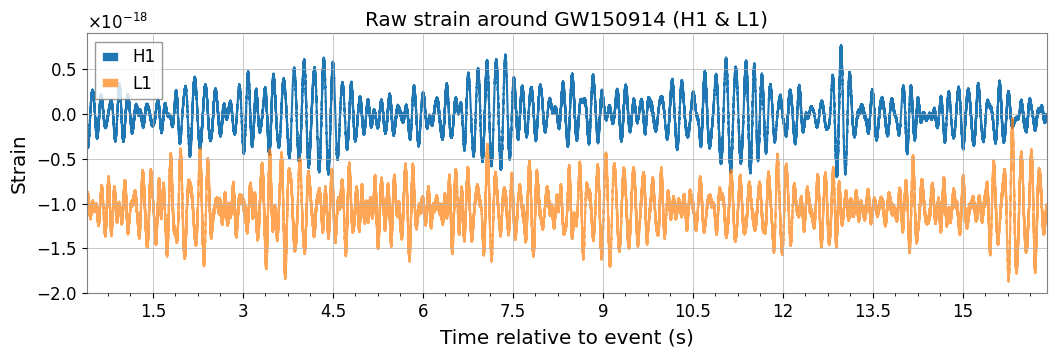

In [ ]:
plt.figure(figsize=(12,4))                                                      #Plotting the raw strain signal of both detectors

plot = Plot(h1, l1, figsize=(12, 4))
ax = plot.gca()
ax.lines[1].set_alpha(0.7)
ax.lines[1].set_label('L1')
ax.lines[0].set_label('H1')

ax.set_xlabel('Time relative to event (s)')
ax.set_ylabel('Strain')
ax.set_title('Raw strain around GW150914 (H1 & L1)')

ax.grid(True)
ax.legend()


In [ ]:
h1_white = h1.whiten(fftlength=4, overlap=2)                                    #Getting rid of the white noise in the Hanford signal
l1_white = l1.whiten(fftlength=4, overlap=2)                                    #Getting rid of the white noise in the Livingston signal

Text(0.5, 1.0, 'Whitened L1 signal')

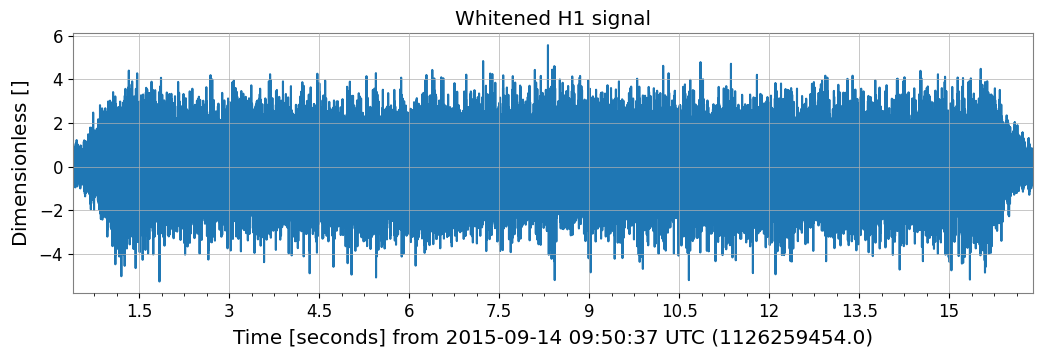

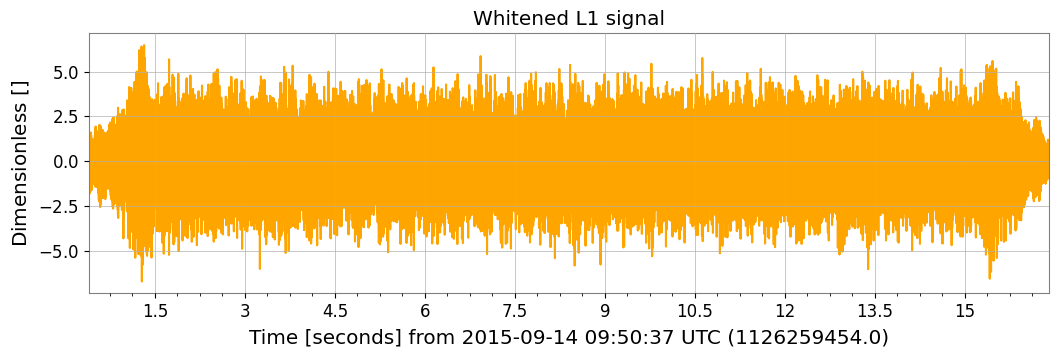

In [ ]:
plot_h_w=h1_white.plot(label='H1')                                              #Plotting the whitened signals
ax_h_w = plot_h_w.gca()
ax_h_w.set_title('Whitened H1 signal')

plot_l_w=l1_white.plot(label='L1', color='orange')
ax_l_w = plot_l_w.gca()
ax_l_w.set_title('Whitened L1 signal')



In [ ]:
def bandpass(data , f_s, f_l , f_h, order):                                     #Defining the band pass filter function
  f_nyq=0.5*f_s
  b , a = butter(order , [f_l/f_nyq , f_h/f_nyq], btype='band')
  return filtfilt(b, a, data)


Text(0.5, 1.0, 'Filtered and whitened L1 signal')

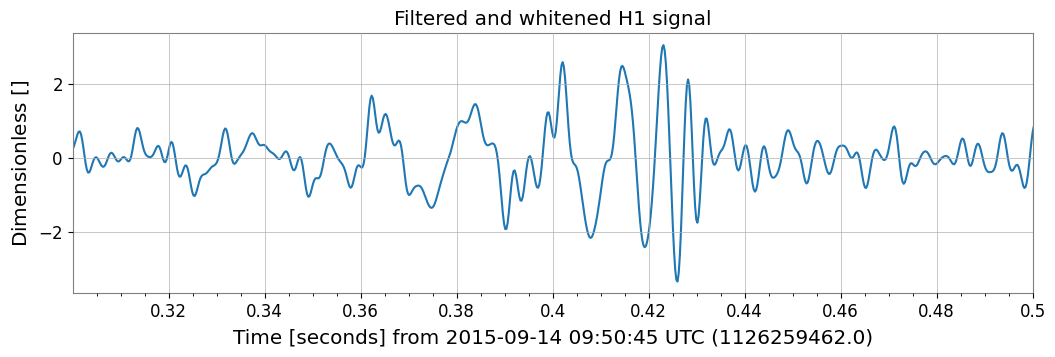

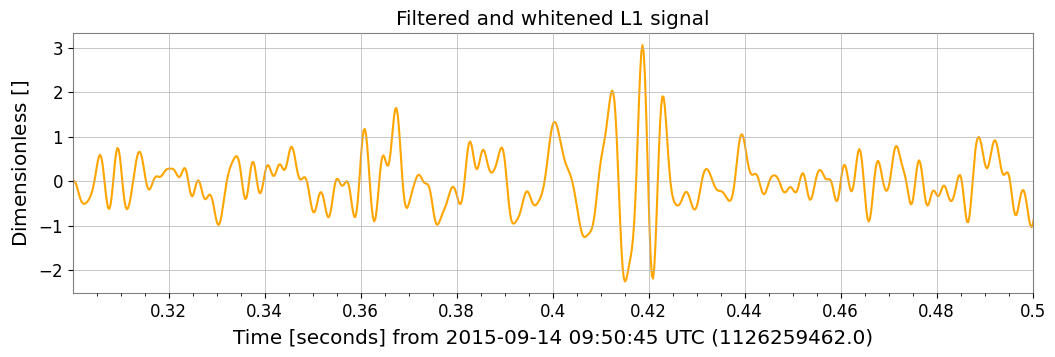

In [ ]:
f_s_h=float(h1.sample_rate.value)                                               #Determining the sampling frequency of the Hanford signal
f_s_l=float(l1.sample_rate.value)                                               #Determining the sampling frequency of the Livingston signal

h1_bp=bandpass(h1_white , f_s_h , 35 , 350 , 4)                                 #Applying the bandpass filter (35-350)Hz to the Hnaford signal
l1_bp=bandpass(l1_white , f_s_l , 35 , 350 , 4)                                 #Applying the bandpass filter (35-350)Hz to the Livingston signal


h1_final = TimeSeries(h1_bp, times=h1.times)                                    #Converting the filtered signals to timeseies
l1_final = TimeSeries(l1_bp, times=l1.times)


plot_h=h1_final.plot(label='H1')                                                #Plotting the filtered signals
ax_h = plot_h.gca()
ax_h.set_xlim(gps-0.1, gps+0.1)
ax_h.set_title('Filtered and whitened H1 signal')

plot_l=l1_final.plot(label='L1', color='orange')
ax_l = plot_l.gca()
ax_l.set_xlim(gps-0.1, gps+0.1)
ax_l.set_title('Filtered and whitened L1 signal')



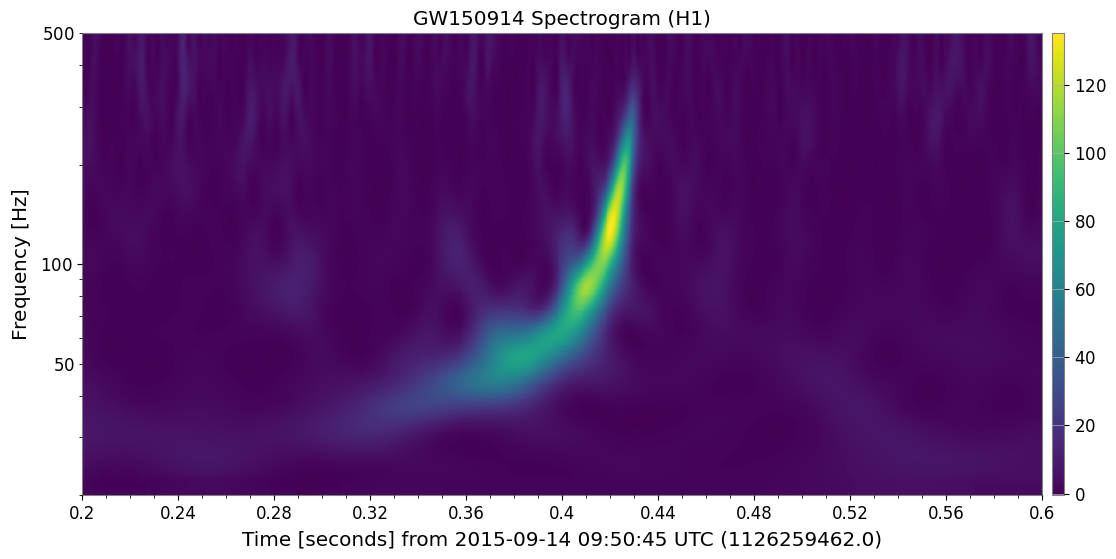

In [ ]:
dt_zoom = 0.2                                                                   #The width to be cropped in the x-axis
outseg = (gps - dt_zoom, gps + dt_zoom)                                         #Cropping the x-axis to optimize the transform

hq = h1_final.q_transform(outseg=outseg, qrange=(4, 8), frange=(20, 500))       #Q-trasnforming the filtered Hanford signal to construct its spectrogram

plot = hq.plot()                                                                #Plotting the spectrogram
ax = plot.gca()

ax.set_yscale('log')
ax.colorbar()
ax.set_title("GW150914 Spectrogram (H1)")
ax.grid(False)


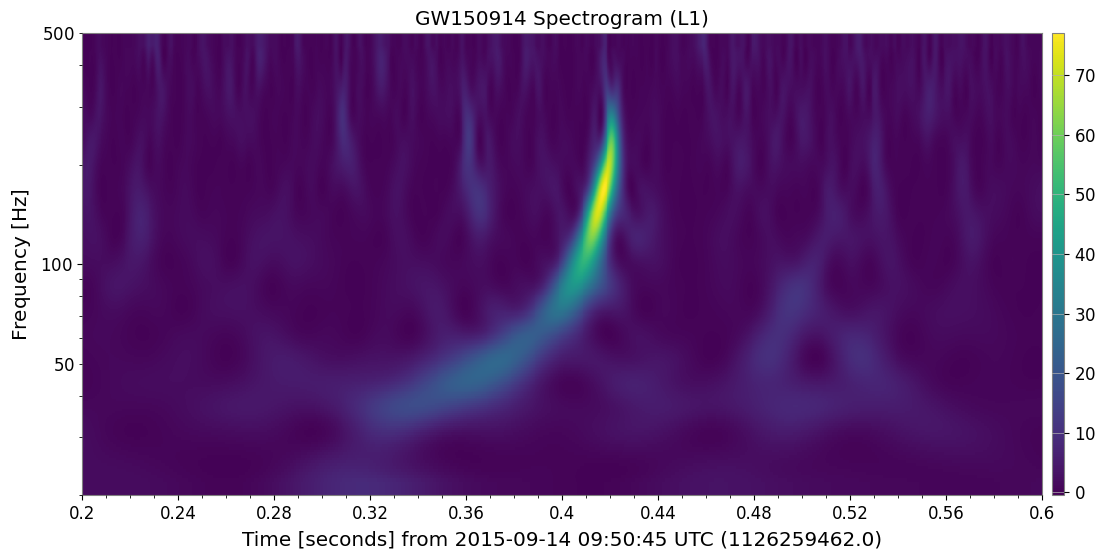

In [ ]:
lq = l1_final.q_transform(outseg=outseg, qrange=(4, 8), frange=(20, 500))       #Q-trasnforming the filtered Livingston signal to construct its spectrogram

plot = lq.plot()                                                                #Plotting the spectrogram
ax = plot.gca()

ax.set_yscale('log')
ax.colorbar()
ax.set_title("GW150914 Spectrogram (L1)")
ax.grid(False)